In [1]:
import os
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import tensorflow as tf

import sys
import getopt


import tensorflow.compat.v1 as tf

from keras import backend as K
from keras.models import Model
from keras.preprocessing import sequence
from keras.utils.data_utils import Sequence
from keras.regularizers import l2
from keras.constraints import non_neg, Constraint
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve


from keras.layers import Input, Concatenate, Flatten
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from tensorflow.keras.optimizers import Nadam, Adam, SGD, Adagrad
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization

import csv
import math
import itertools

from tensorflow.keras import utils as ku 

import pickle

from nltk.util import ngrams

import keras
print(keras.__version__)


# from google.colab import drive
# drive.mount('/content/drive')

2.5.0


#### Testing the main function section by section and Understanding the code

Bemali Wickramanayake

From this section of the notebook, we try to understand the support code that is written above by testing the main function section by section

In [2]:
MY_WORKSPACE_DIR = os.path.join(os.getcwd(),"BPIC_11")
# MY_WORKSPACE_DIR = "/content/drive/My Drive/BPIC_11/"

In [3]:
def catch_parameter(opt):
    """Change the captured parameters names"""
    switch = {'-h':'help', '-i':'imp', '-l':'lstm_act',
              '-d':'dense_act', '-n':'norm_method', '-f':'folder',
              '-m':'model_file', '-t':'model_type', '-a':'activity',
              '-e':'file_name', '-b':'n_size', '-c':'l_size', '-o':'optim'}
    try:
        return switch[opt]
    except:
        raise Exception('Invalid option ' + opt)



# --setup--
#def main():
#    """Main aplication method"""
timeformat = '%Y-%m-%dT%H:%M:%S.%f'
parameters = dict()
#   Parameters setting manual fixed or catched by console for batch operations
   
parameters['folder'] = os.path.join(MY_WORKSPACE_DIR, "output_files")
# parameters['folder'] = "/content/drive/My Drive/BPIC_11/output_files/"
#       Specific model training parameters
parameters['imp'] = 1 # keras lstm implementation 1 cpu, 2 gpu
parameters['lstm_act'] = None # optimization function see keras doc
parameters['dense_act'] = None # optimization function see keras doc
parameters['optim'] = 'Adagrad' #'Adagrad' # optimization function see keras doc
parameters['norm_method'] = 'lognorm' # max, lognorm
                # Model types --> specialized, concatenated, shared_cat, joint, shared
parameters['model_type'] = 'shared_cat'
parameters['l_size'] = 50 # LSTM layer sizes
#       Generation parameters
parameters['folder'] = os.path.join(MY_WORKSPACE_DIR, "output_files")
# parameters['folder'] = "/content/drive/My Drive/BPIC_11/output_files/"
parameters['file_name'] = os.path.join(MY_WORKSPACE_DIR, 'BPIC_2011_A.csv') #'BPI_2012_W_complete.xes.gz'
parameters['processed_file_name'] = os.path.join(MY_WORKSPACE_DIR, 'BPIC_2011_Processed.csv') 
parameters['processed_training_vec'] = os.path.join(MY_WORKSPACE_DIR, 'vec_training.p')
parameters['processed_test_vec'] = os.path.join(MY_WORKSPACE_DIR, 'vec_test.p')
parameters['weights'] = os.path.join(MY_WORKSPACE_DIR, 'weights.p') 
parameters['indexes'] = os.path.join(MY_WORKSPACE_DIR, 'indexes.p')
parameters['args'] = os.path.join(MY_WORKSPACE_DIR, 'args.p') 

    #parameters['model_file'] = 'model_rd_100 Nadam_02-0.90.h5'
parameters['n_size'] = 15 # n-gram size

parameters['log_name'] = 'bpic2011_Hospital_Data'

parameters['task']='outcome'
    
    #training_model(timeformat, parameters)
    
 


#if __name__ == "__main__":
#  main()

In [4]:
args = parameters
args

{'folder': 'c:\\Users\\mithr\\Documents\\GitHub\\Explainable-DL-ProcessPredictionss\\BPIC_11\\output_files',
 'imp': 1,
 'lstm_act': None,
 'dense_act': None,
 'optim': 'Adagrad',
 'norm_method': 'lognorm',
 'model_type': 'shared_cat',
 'l_size': 50,
 'file_name': 'c:\\Users\\mithr\\Documents\\GitHub\\Explainable-DL-ProcessPredictionss\\BPIC_11\\BPIC_2011_A.csv',
 'processed_file_name': 'c:\\Users\\mithr\\Documents\\GitHub\\Explainable-DL-ProcessPredictionss\\BPIC_11\\BPIC_2011_Processed.csv',
 'processed_training_vec': 'c:\\Users\\mithr\\Documents\\GitHub\\Explainable-DL-ProcessPredictionss\\BPIC_11\\vec_training.p',
 'processed_test_vec': 'c:\\Users\\mithr\\Documents\\GitHub\\Explainable-DL-ProcessPredictionss\\BPIC_11\\vec_test.p',
 'weights': 'c:\\Users\\mithr\\Documents\\GitHub\\Explainable-DL-ProcessPredictionss\\BPIC_11\\weights.p',
 'indexes': 'c:\\Users\\mithr\\Documents\\GitHub\\Explainable-DL-ProcessPredictionss\\BPIC_11\\indexes.p',
 'args': 'c:\\Users\\mithr\\Documents\\Gi

Read the log file based on the parameters given above

In [5]:
# Create the event log dataframe

# Dataframe creation
log_df = pd.read_csv(args['file_name'])
log_df = log_df.reset_index(drop=True)

log_df

,caseid,activity,department,Timestamp,activity_code,executions,producer_code,section,age,Diagnosis_code,treatment_code,Year,Diagnosis
0,0,1e consult poliklinisch,Radiotherapy,3/01/2005,410100,1,SRTH,Section 5,33,106,23,0,gynecological tumors
1,0,administratief tarief - eerste pol,Radiotherapy,3/01/2005,419100,1,SRTH,Section 5,33,106,23,0,gynecological tumors
2,0,verlosk.-gynaec. korte kaart kosten-out,Nursing ward,5/01/2005,10107,1,SGEH,Section 2,33,106,23,0,gynecological tumors
3,0,echografie - genitalia interna,Obstetrics & Gynaecology clinic,5/01/2005,339486E,1,SGEC,Section 2,33,106,23,0,gynecological tumors
4,0,1e consult poliklinisch,Nursing ward,5/01/2005,410100,1,SGEH,Section 2,33,106,23,0,gynecological tumors
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147059,1141,screening antistoffen erytrocyten,General Lab Clinical Chemistry,18/03/2008,378607,1,BLOB,Section 4,60,M13,803,0,Cancer-Cervix
147060,1141,differentiatie leukocyten - handmatig,General Lab Clinical Chemistry,18/03/2008,379000A,1,HAEM,Section 4,60,M13,803,0,Cancer-Cervix
147061,1141,ordertarief,General Lab Clinical Chemistry,18/03/2008,379999,1,CRLA,Section 4,60,M13,803,0,Cancer-Cervix
147062,1141,1e consult poliklinisch,Obstetrics & Gynaecology clinic,18/03/2008,410100,1,SGNA,Section 2,60,M13,803,0,Cancer-Cervix


#### Support Function 1: Add calculated Features
Author: Bemali Wickramanayake
Function: Adds features to the existing dataframe
* end_timestamp: The existing dataset has only one timestamp. we create the end timestamp using the preceding activity's timestamp
* case_len: Total trace duration for a given case - this will be a static variable
* tbtw: Time between two consecutive activities

In [12]:
# 

# ==============================================================================
# Data Preprocessing - Add calculated features
# =============================================================================

#df = log_df

def add_calculated_features(df):

  #Adds
  # end_timestamp
  # case_len : total case duration from the start to end
  # tbtw : activity length

  df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y')

  column_list = ['caseid', 'activity', 'department', 'Timestamp', 'activity_code',
       'executions', 'producer_code', 'section', 'age', 'Diagnosis_code',
       'treatment_code', 'Year', 'Diagnosis', 'case_len','tbtw']
  new_column_list = ['caseid', 'activity', 'department', 'start_timestamp', 'activity_code',
       'executions', 'producer_code', 'section', 'age', 'diagnosis',
       'treatment_code', 'years', 'diagnosis_group', 'case_len','tbtw']

  df_new = pd.DataFrame(columns=column_list)

  cases = df.caseid.unique()
  for case in cases:

    df_temp = df[df['caseid']==case] 
    df_temp['case_len']=max(df_temp['Timestamp'])-min(df_temp['Timestamp'])
    df_temp['tbtw']=df_temp['Timestamp']-min(df_temp['Timestamp']) #time lapsed from the start of first activity

    df_new = df_new.append(df_temp)


  df_new = df_new.drop_duplicates()
  df_new['case_len']= pd.to_numeric(df_new['case_len'].dt.days, downcast='integer')
  df_new['tbtw']= pd.to_numeric(df_new['tbtw'].dt.days, downcast='integer')
  df_new.columns= new_column_list

  return df_new






In [13]:
df_log = add_calculated_features(log_df)
df_log.head()

ctivity
<ipython-input-12-fb60c3b019a9>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['case_len']=max(df_temp['Timestamp'])-min(df_temp['Timestamp'])
<ipython-input-12-fb60c3b019a9>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['tbtw']=df_temp['Timestamp']-min(df_temp['Timestamp']) #time lapsed from the start of first activity
<ipython-input-12-fb60c3b019a9>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

,caseid,activity,department,start_timestamp,activity_code,executions,producer_code,section,age,diagnosis,treatment_code,years,diagnosis_group,case_len,tbtw
0,0,1e consult poliklinisch,Radiotherapy,2005-01-03,410100,1,SRTH,Section 5,33,106,23,0,gynecological tumors,66,0
1,0,administratief tarief - eerste pol,Radiotherapy,2005-01-03,419100,1,SRTH,Section 5,33,106,23,0,gynecological tumors,66,0
2,0,verlosk.-gynaec. korte kaart kosten-out,Nursing ward,2005-01-05,10107,1,SGEH,Section 2,33,106,23,0,gynecological tumors,66,2
3,0,echografie - genitalia interna,Obstetrics & Gynaecology clinic,2005-01-05,339486E,1,SGEC,Section 2,33,106,23,0,gynecological tumors,66,2
4,0,1e consult poliklinisch,Nursing ward,2005-01-05,410100,1,SGEH,Section 2,33,106,23,0,gynecological tumors,66,2


In [14]:
df_log.to_csv(args['processed_file_name'],index=False)

In [15]:
log_df = pd.read_csv(args['processed_file_name'])
log_df = log_df.reset_index(drop=True)
log_df.head()


,caseid,activity,department,start_timestamp,activity_code,executions,producer_code,section,age,diagnosis,treatment_code,years,diagnosis_group,case_len,tbtw
0,0,1e consult poliklinisch,Radiotherapy,2005-01-03,410100,1,SRTH,Section 5,33,106,23,0,gynecological tumors,66,0
1,0,administratief tarief - eerste pol,Radiotherapy,2005-01-03,419100,1,SRTH,Section 5,33,106,23,0,gynecological tumors,66,0
2,0,verlosk.-gynaec. korte kaart kosten-out,Nursing ward,2005-01-05,10107,1,SGEH,Section 2,33,106,23,0,gynecological tumors,66,2
3,0,echografie - genitalia interna,Obstetrics & Gynaecology clinic,2005-01-05,339486E,1,SGEC,Section 2,33,106,23,0,gynecological tumors,66,2
4,0,1e consult poliklinisch,Nursing ward,2005-01-05,410100,1,SGEH,Section 2,33,106,23,0,gynecological tumors,66,2


#### Data Analysis - Balance of Data Set

In [18]:
#Checking the Balance of the Dataset, by the target variable
print('Distribution of cases by the target variable - diagnosis\n')
print(log_df.groupby(['diagnosis'])['caseid'].nunique())

Distribution of cases by the target variable - diagnosis

diagnosis
106    226
821     23
822     15
823      9
839     13
M11    168
M12     19
M13    304
M14    113
M15     15
M16    225
Name: caseid, dtype: int64


We can see that there is an imbalance in the dataset, by the diagnosis.
Therefore, we can reduce the imbalance of data by grouping some of the diagnoses.

We use the logic below to perform the same, based on the paper by Bose and Aalst

@inproceedings{Bose2011AnalysisOP,
  title={Analysis of patient treatment procedures: The BPI Challenge case study},
  author={R. P. J. C. Bose and W. Aalst},
  year={2011}
}

* 821 group with m16
* 822 group with m13
* 823 group with 839 and discarded (minority class, multiple types of cancers)
* m12  discarded (minority class)
* m15 group with m14

#### Support Function 2: Grouping Target Variables
Author: Bemali Wickramanayake

Function: Groups the Diagnoses codes to balance the dataset

In [19]:
def balance(df):
  # Dictonary with the mapping of columns
  group_dict = {'106':'106',
  '821' :'M16',
  '822' :'M13',
  '823' :'839',
  '839' :'839',
  'M11' :'M11',
  'M12' :'M12',
  'M13' :'M13',
  'M14' :'M14',
  'M15' :'M14',
  'M16' :'M16'}

  
  df['diagnosis'].replace(group_dict, inplace=True)
  #Dropping the minority classes
  df = df.drop(df[df.diagnosis == '839'].index)
  df = df.drop(df[df.diagnosis == 'M12'].index)

  return df



Balancing the dataset

In [20]:
log_df = balance(log_df)

In [21]:
# Check the balance

print('Distribution of cases by the target variable - diagnosis\n')
print(log_df.groupby(['diagnosis'])['caseid'].nunique())

Distribution of cases by the target variable - diagnosis

diagnosis
106    226
M11    168
M13    319
M14    128
M16    248
Name: caseid, dtype: int64


#### Support Function 3: Create indexes
Author: Renuka Sindagatta/ Manuel Camargo

Function: creates an index (index encoded set) for a given categorical column.

In [22]:
def create_index(log_df, column):
    """Creates an idx for a categorical attribute.
    Args:
        log_df: dataframe.
        column: column name.
    Returns:
        index of a categorical attribute pairs.
    """
    temp_list = log_df[[column]].values.tolist()
    subsec_set = {(x[0]) for x in temp_list}
    subsec_set = sorted(list(subsec_set))
    alias = dict()
    if column !='diagnosis':
      for i, _ in enumerate(subsec_set):
          alias[subsec_set[i]] = i + 1
    else:
      for i, _ in enumerate(subsec_set):
          alias[subsec_set[i]] = i  
    return alias

create the indexes for the processed dataframe

In [23]:
# Index creation for activity

ac_index = create_index(log_df, 'activity')
ac_index['start'] = 0
ac_index['end'] = len(ac_index)
index_ac = {v: k for k, v in ac_index.items()}

# Index creation for department/role

rl_index = create_index(log_df, 'department')
rl_index['start'] = 0
rl_index['end'] = len(rl_index)
index_rl = {v: k for k, v in rl_index.items()}

# Index creation for Diagnosis

di_index = create_index(log_df, 'diagnosis')

index_di = {v: k for k, v in di_index.items()}

#mapping the dictionary values as columns in the dataframe
log_df['ac_index'] = log_df['activity'].map(ac_index)
log_df['rl_index'] = log_df['department'].map(rl_index)
log_df['di_index'] = log_df['diagnosis'].map(di_index)

print(rl_index)
print(index_rl)
log_df.head()




{'Anesthesiology': 1, 'Anesthesiology clinic': 2, 'Cardiovascular clinics': 3, 'Day Centre - treatment': 4, 'Day Centre - ward': 5, 'Diet Studies': 6, 'Emergency room': 7, 'Endoscopy': 8, 'Function Centre ENT': 9, 'General Lab Clinical Chemistry': 10, 'Hyper Pressure Tank': 11, 'ICU Adults': 12, 'IVF clinic': 13, 'Internal Specialisms clinic': 14, 'Lab Experimental Immunology': 15, 'Lab Hematology': 16, 'Maternity ward': 17, 'Medical Microbiology': 18, 'Nuclear Medicine': 19, 'Nursing ward': 20, 'Obstetrics & Gynaecology clinic': 21, 'Operating rooms': 22, 'Ophthalmology clinic': 23, 'Pain clinic': 24, 'Pathology': 25, 'Pharmacy Laboratory': 26, 'Radiology': 27, 'Radiotherapy': 28, 'Recovery room / high care': 29, 'Special lab Nuro sensory': 30, 'Special lab radiology': 31, 'surgery & urology clinic': 32, 'start': 0, 'end': 33}
{1: 'Anesthesiology', 2: 'Anesthesiology clinic', 3: 'Cardiovascular clinics', 4: 'Day Centre - treatment', 5: 'Day Centre - ward', 6: 'Diet Studies', 7: 'Emerg

,caseid,activity,department,start_timestamp,activity_code,executions,producer_code,section,age,diagnosis,treatment_code,years,diagnosis_group,case_len,tbtw,ac_index,rl_index,di_index
0,0,1e consult poliklinisch,Radiotherapy,2005-01-03,410100,1,SRTH,Section 5,33,106,23,0,gynecological tumors,66,0,7,28,0
1,0,administratief tarief - eerste pol,Radiotherapy,2005-01-03,419100,1,SRTH,Section 5,33,106,23,0,gynecological tumors,66,0,10,28,0
2,0,verlosk.-gynaec. korte kaart kosten-out,Nursing ward,2005-01-05,10107,1,SGEH,Section 2,33,106,23,0,gynecological tumors,66,2,194,20,0
3,0,echografie - genitalia interna,Obstetrics & Gynaecology clinic,2005-01-05,339486E,1,SGEC,Section 2,33,106,23,0,gynecological tumors,66,2,84,21,0
4,0,1e consult poliklinisch,Nursing ward,2005-01-05,410100,1,SGEH,Section 2,33,106,23,0,gynecological tumors,66,2,7,20,0


#### Data Analysis - Correlation between features

credits: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

<AxesSubplot:>

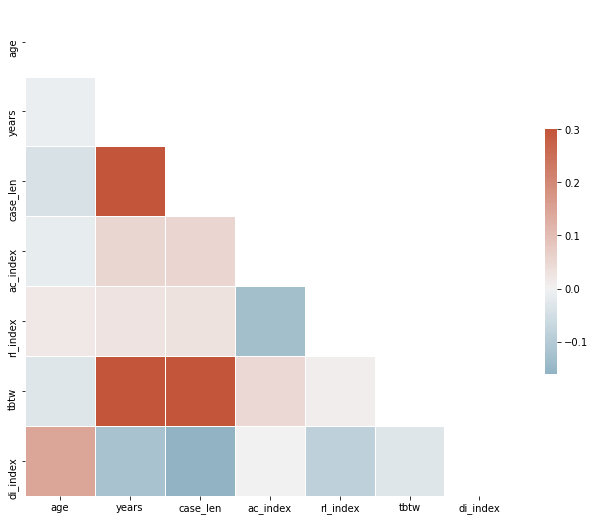

In [24]:
cor_columns = ['age','years','case_len','ac_index','rl_index','tbtw','di_index']
d = log_df[cor_columns]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Support Function 4: Split train test
Author: Renuka Sindagatta/ Manuel Camargo

Function: divides the dataset into test and train sets, preserving traces

In [25]:
# =============================================================================
# Split an event log dataframe to peform split-validation 
# =============================================================================
def split_train_test(df, percentage):
    cases = df.caseid.unique()
    num_test_cases = int(np.round(len(cases)*percentage))
    test_cases = cases[:num_test_cases]
    train_cases = cases[num_test_cases:]
    df_train, df_test = pd.DataFrame(), pd.DataFrame()
    for case in train_cases:
        df_train = df_train.append(df[df.caseid==case]) 
    df_train = df_train.sort_values('start_timestamp', ascending=True).reset_index(drop=True)
 
    for case in test_cases:
        df_test = df_test.append(df[df.caseid==case]) 
    df_test = df_test.sort_values('start_timestamp', ascending=True).reset_index(drop=True)
    
    return df_train, df_test 

splitting the dataframe into test and train sets


In [26]:
# Split validation datasets
log_df_train, log_df_test = split_train_test(log_df, 0.3) # 70%/30%

#### Support Function 5: normalize_events
Modified from the function of: Renuka Sindagatta/ Manuel Camargo

Function: Normalizes the numerical features

In [27]:
def normalize_events(log_df,args,features):

#log_df(DataFrame): The dataframe with eventlog data
#args(Dictionary): The set of parameters
#Returns a Dataframe with normalized numerical features
  for feature in features:
    if args['norm_method'] == 'max':
        mean_feature = np.mean(log_df.feature)
        std_feature = np.std(log_df.feature)
        norm = lambda x: (x[feature]-mean_feature)/std_feature
        log_df['%s_norm'%(feature)] = log_df.apply(norm, axis=1)
    elif args['norm_method'] == 'lognorm':
        logit = lambda x: math.log1p(x[feature])
        log_df['%s_log'%(feature)] = log_df.apply(logit, axis=1)
        mean_feature = np.mean(log_df['%s_log'%(feature)])
        std_feature=np.std(log_df['%s_log'%(feature)])
        norm = lambda x: (x['%s_log'%(feature)]-mean_feature)/std_feature
        log_df['%s_norm'%(feature)] = log_df.apply(norm, axis=1)
  return log_df

Adding normalized features: to the training set

In [28]:
numerical_features = ['age','years','case_len','tbtw']
log_df_train = normalize_events(log_df_train,args,numerical_features)
log_df_test = normalize_events(log_df_test,args,numerical_features)
log_df_train.head()


,caseid,activity,department,start_timestamp,activity_code,executions,producer_code,section,age,diagnosis,...,rl_index,di_index,age_log,age_norm,years_log,years_norm,case_len_log,case_len_norm,tbtw_log,tbtw_norm
0,338,verlosk.-gynaec. jaarkaart kosten-out,Obstetrics & Gynaecology clinic,2005-07-22,10307,1,SGNA,Section 2,37,M16,...,21,4,3.637586,-1.128957,0.000000,-0.881393,4.510860,-0.875326,0.0,-1.951919
1,341,cito histologisch onderzoek,Pathology,2005-07-25,359999,1,LVPT,Section 4,59,M16,...,25,4,4.094345,0.396624,1.098612,1.717064,6.840547,1.157415,0.0,-1.951919
2,341,aanname laboratoriumonderzoek,General Lab Clinical Chemistry,2005-07-25,370000,1,CRLA,Section 4,59,M16,...,10,4,4.094345,0.396624,1.098612,1.717064,6.840547,1.157415,0.0,-1.951919
3,341,bilirubine kwantitatief totaal of direct,General Lab Clinical Chemistry,2005-07-25,370401S,1,CHE2,Section 4,59,M16,...,10,4,4.094345,0.396624,1.098612,1.717064,6.840547,1.157415,0.0,-1.951919
4,341,ureum - spoed,General Lab Clinical Chemistry,2005-07-25,370403S,1,CHE2,Section 4,59,M16,...,10,4,4.094345,0.396624,1.098612,1.717064,6.840547,1.157415,0.0,-1.951919


In [29]:
training_traces = len(log_df_train['caseid'].unique())
test_traces = len(log_df_test['caseid'].unique())

print('Number of traces in training set is:'+str(training_traces))
print('Number of traces in test set is:'+str(test_traces))

Number of traces in training set is:762
Number of traces in test set is:327


In [30]:
#Checking the Balance of the Dataset, by the target variable
print('training dataset')
print(log_df_train.groupby(['diagnosis'])['caseid'].nunique())

print('test dataset')
print(log_df_test.groupby(['diagnosis'])['caseid'].nunique())



training dataset
diagnosis
106    174
M11    105
M13    210
M14    101
M16    172
Name: caseid, dtype: int64
test dataset
diagnosis
106     52
M11     63
M13    109
M14     27
M16     76
Name: caseid, dtype: int64


#### Support Function 6: Reformat events
Modified from the function of: Renuka Sindagatta/ Manuel Camargo

Function: converts the dataframe into a dictionary, using the indexes created

In [31]:
# ==============================================================================
# Reformat events: converts the dataframe into a numerical dictionary
# ==============================================================================

def reformat_events(log_df, ac_index, rl_index,di_index):
    """Creates series of activities, roles and relative times per trace.
    Args:
        log_df: dataframe.
        ac_index (dict): index of activities.
        rl_index (dict): index of roles.
    Returns:
        list: lists of activities, roles and relative times.
    """
    log_df = log_df.to_dict('records')

    temp_data = list()
    log_df = sorted(log_df, key=lambda x: (x['caseid'], x['start_timestamp']))
    for key, group in itertools.groupby(log_df, key=lambda x: x['caseid']):
        trace = list(group)
        #dynamic features
        ac_order = [x['ac_index'] for x in trace]
        rl_order = [x['rl_index'] for x in trace]
        tbtw = [x['tbtw_norm'] for x in trace]

        #static features: the aggregation used is max(), however, any aggregation could be used since we have a single value for this for the whole trace
        age = max(x['age_norm'] for x in trace)
        years = max(x['years_norm'] for x in trace)
        case_len = max(x['case_len_norm'] for x in trace)

        #outcome
        diagnosis = max(x['di_index'] for x in trace)

        #Adding start and end to the dynamic features
        ac_order.insert(0, ac_index[('start')])
        ac_order.append(ac_index[('end')])
        rl_order.insert(0, rl_index[('start')])
        rl_order.append(rl_index[('end')])
        tbtw.insert(0, 0)
        tbtw.append(0)
        temp_dict = dict(caseid=key,
                         ac_order=ac_order,
                         rl_order=rl_order,
                         tbtw=tbtw,
                         age=age,
                         years=years,
                         case_len= case_len,
                         diagnosis = diagnosis)
        temp_data.append(temp_dict)

    return temp_data


converting the training dataframe into a dictionary


In [32]:

log_train = reformat_events(log_df_train, ac_index, rl_index,di_index)
log_test = reformat_events(log_df_test, ac_index, rl_index,di_index)

In [33]:
#print a sample of the dictionary
print(log_train[700])

{'caseid': 1069, 'ac_order': [0, 3, 172, 1, 5, 159, 8, 149, 133, 160, 12, 59, 43, 91, 178, 127, 99, 125, 139, 8, 29, 184, 34, 57, 100, 145, 117, 163, 165, 16, 127, 5, 3, 3, 5, 127, 73, 3, 5, 63, 127, 92, 3, 5, 10, 7, 65, 149, 133, 160, 12, 123, 35, 45, 91, 178, 125, 75, 159, 34, 43, 165, 163, 117, 145, 16, 57, 100, 184, 29, 8, 8, 127, 87, 139, 127, 8, 100, 149, 167, 5, 3, 127, 3, 5, 170, 23, 3, 5, 127, 127, 5, 3, 5, 127, 3, 127, 3, 5, 127, 112, 5, 3, 3, 127, 5, 3, 5, 127, 5, 127, 3, 127, 5, 3, 3, 5, 127, 73, 3, 5, 127, 3, 5, 127, 169, 200], 'rl_order': [0, 20, 27, 20, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 20, 20, 20, 20, 20, 6, 20, 20, 27, 20, 10, 20, 20, 28, 28, 27, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 20, 10, 10, 10, 27, 20, 20, 20, 20, 20, 28, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

#### Support Function 7: Vectorization
Author: Bemali Wickramanayake

Inspired by the code of: Renuka Sindagatta

Function: Creating the Input and Output Tensors 

Notes: Editing needs to finish for this function

In [34]:
# Support function for Vectirization

# This function returns the maximum trace length (trc_len), and the number of cases for train and test sets (cases)
# The maximum out of trc_len for train and test sets will be used to define the trace length of the dataset that is fed to lstm

def lengths (log):
  trc_len = 1
  cases = 1

  for i,_ in enumerate(log):

    if trc_len <len(log[i]['ac_order']):

        trc_len = len(log[i]['ac_order'])
        cases += 1
    else:
        cases += 1

  return trc_len, cases


In [35]:
#Obtain the trc_len and cases for each set

trc_len_train, cases_train = lengths(log_train)
trc_len_test, cases_test = lengths(log_test)

trc_len = trc_len_train
if trc_len < trc_len_test:
  trc_len = trc_len_test

print("trace_length: "+str(trc_len)+", training cases: "+str(cases_train)+", test cases: "+str(cases_test))



trace_length: 1402, training cases: 763, test cases: 328


In [36]:
def vectorization(log, ac_index, rl_index, di_index,trc_len,cases):

#Example function with types documented in the docstring.
#Args:
        #log: event log data in a dictionary.
        #ac_index (dict): index of activities.
        #rl_index (dict): index of roles (departments).
        #di_index (dict) : index of diagnosis codes.

#Returns:vec: Dictionary that contains all the LSTM inputs. """

  vec = {'prefixes':dict(), 'static':dict(),'diagnosis':[]} 
  len_ac = trc_len  

  for i ,_ in enumerate(log):
  
    padding = np.zeros(len_ac-len(log[i]['ac_order']))

    if i == 0:
            vec['prefixes']['x_ac_inp'] = np.array(np.append(log[i]['ac_order'],padding))
            vec['prefixes']['x_rl_inp'] = np.array(np.append(log[i]['rl_order'],padding))
            vec['prefixes']['xt_inp'] = np.array(np.append(log[i]['tbtw'],padding))
            vec['static']['x_age_inp'] = np.array(log[i]['age'])
            vec['static']['x_years_inp'] = np.array(log[i]['years'])
            vec['static']['x_cl_inp'] = np.array(log[i]['case_len'])
            vec['diagnosis'] = np.array(log[i]['diagnosis'])


            #print(len(vec['prefixes']['x_ac_inp']))

  
    vec['prefixes']['x_ac_inp'] = np.concatenate((vec['prefixes']['x_ac_inp'],
                                                          np.array(np.append(log[i]['ac_order'],padding))), axis=0)
    vec['prefixes']['x_rl_inp'] = np.concatenate((vec['prefixes']['x_rl_inp'],
                                                          np.array(np.append(log[i]['rl_order'],padding))), axis=0)
    vec['prefixes']['xt_inp'] = np.concatenate((vec['prefixes']['xt_inp'],
                                                        np.array(np.append(log[i]['tbtw'],padding))), axis=0)
    vec['static']['x_age_inp'] = np.append(vec['static']['x_age_inp'],log[i]['age'])
    vec['static']['x_years_inp'] = np.append(vec['static']['x_years_inp'],log[i]['years'])
    vec['static']['x_cl_inp'] = np.append(vec['static']['x_cl_inp'],log[i]['case_len'])
    vec['diagnosis'] = np.append(vec['diagnosis'],log[i]['diagnosis'])
  

  

  
  #The concatenation returns a flattened vector. Hence, reshaping the vectors at the end
  vec['prefixes']['x_ac_inp'] = np.reshape(vec['prefixes']['x_ac_inp'],(cases,len_ac))
  vec['prefixes']['x_rl_inp'] = np.reshape(vec['prefixes']['x_rl_inp'],(cases,len_ac))
  vec['prefixes']['xt_inp'] = np.reshape(vec['prefixes']['xt_inp'],(cases,len_ac))

  #one-hot-encoding the y class
  vec['diagnosis'] = ku.to_categorical(vec['diagnosis'],
                                               num_classes=len(di_index))

  return vec


converting the training log (dictionary) into a Tensor

In [37]:
vec_train = vectorization(log_train,ac_index,rl_index,di_index,trc_len,cases_train)
vec_test = vectorization(log_test,ac_index,rl_index,di_index,trc_len,cases_test)

In [38]:
vec_train['diagnosis']

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]], dtype=float32)

#### Initial Embedding weights for the Embedding layer

In [39]:
# Load embedded matrix
ac_weights = ku.to_categorical(sorted(index_ac.keys()), len(ac_index))
#print('AC_WEIGHTS', ac_weights)
rl_weights =  ku.to_categorical(sorted(index_rl.keys()), len(rl_index))
#print('RL_WEIGHTS', rl_weights)


#### Saving the Processed Tensor and Other Support Data

In [40]:

# saving the processed tensor
with open(args['processed_training_vec'], 'wb') as fp:
    pickle.dump(vec_train, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(args['processed_test_vec'], 'wb') as fp:
    pickle.dump(vec_test, fp, protocol=pickle.HIGHEST_PROTOCOL)

# converting the weights into a dictionary and saving
weights = {'ac_weights':ac_weights, 'rl_weights':rl_weights, 'diagnoses':len(di_index)}
with open(args['weights'], 'wb') as fp:
    pickle.dump(weights, fp, protocol=pickle.HIGHEST_PROTOCOL)

# converting the weights into a dictionary and saving
indexes = {'index_ac':index_ac, 'index_rl':index_rl, 'index_di':index_di}
with open(args['indexes'], 'wb') as fp:
    pickle.dump(indexes, fp, protocol=pickle.HIGHEST_PROTOCOL)

#saving the arguements (args)
with open(args['args'], 'wb') as fp:
    pickle.dump(args, fp, protocol=pickle.HIGHEST_PROTOCOL)


